# Visualization using T-SNE(DenseNet-121)

## Settings

**Import Module**

In [30]:
print(os.path.abspath(os.path.dirname(os.getcwd())))
print(os.path.join(os.path.abspath(os.path.dirname(os.getcwd())),'Chexpert'))
print(os.path.join(os.path.abspath(os.path.dirname(os.getcwd())),'XTransformer'))
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(os.path.join(os.path.abspath(os.path.dirname(os.getcwd())),'Chexpert'))
sys.path.append(os.path.join(os.path.abspath(os.path.dirname(os.getcwd())),'XTransformer'))

/home/mskang/jinsu/med
/home/mskang/jinsu/med/Chexpert
/home/mskang/jinsu/med/XTransformer


In [31]:
from sklearn.manifold import TSNE

import sys
from easydict import EasyDict as edict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image



import warnings

warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

from torchvision import transforms as T
import torch
import json
# import argparse

from Chexpert.model.backbone import densenet
from Chexpert.model.classifier import Classifier

from XTransformer.main_mimic import load_encoder_model

**Load Models**

In [32]:
with open('/home/mskang/jinsu/med/Chexpert/config/example.json') as f:
    encoder_cfg = edict(json.load(f))

# ImageNet
encoder_cfg.pretrained = True    
model = densenet.densenet121(encoder_cfg)
ImageNet = model.features

# Chexpert

pretrained_path = '/home/mskang/jinsu/med/Chexpert/config/pre_train.pth'
model = Classifier(encoder_cfg)
state_dict = torch.load(pretrained_path)
model.load_state_dict(state_dict)
CheXpert= model.backbone.features

# Mimic 
folder_path = '/home/mskang/jinsu/med/XTransformer/experiments/x_transformer+_ca30_512_dense_x2_CheXpert_fc_dropout_schedule_concat'
resume = 106

Mimic, cfg= load_encoder_model(folder_path, resume)



# Eval

ImageNet.eval().to("cuda")
CheXpert.eval().to("cuda")
Mimic.eval().to("cuda")
pass



Called with args:
/home/mskang/jinsu/med/XTransformer/experiments/x_transformer+_ca30_512_dense_x2_CheXpert_fc_dropout_schedule_concat
Namespace(folder='/home/mskang/jinsu/med/XTransformer/experiments/x_transformer+_ca30_512_dense_x2_CheXpert_fc_dropout_schedule_concat', local_rank=0, resume=106)
denseNet121 + Chexpert
Load Pre-Trained Encoder :  Chexpert.pth
start Getting Model..
Load Chexpert-pretrained densenet-121 :  /home/mskang/jinsu/med/XTransformer/experiments/x_transformer+_ca30_512_dense_x2_CheXpert_fc_dropout_schedule_concat/Chexpert.pth
Use DeTR with contra_attention_block(# of normal images : 30)
Training through resume : model 106


**Image folder** + **Label**

In [33]:
input_folder = os.path.join('/home/mskang/jinsu/med/XTransformer', cfg.DATA_LOADER.TEST_INPUT_IMAGES)
test_id = os.path.join('/home/mskang/jinsu/med/XTransformer', cfg.DATA_LOADER.TEST_ID)
# all_id = os.path.join('/home/mskang/jinsu/med/XTransformer', cfg.DATA_LOADER.ALL_ID)
print(input_folder)
print(test_id)
# print(all_id)

mimic_test = '/home/mskang/jinsu/med/H_LSTM_Transformer/data/new_data_mimic/mimic_test.txt'
master_sheet = '/home/mskang/jinsu/med/H_LSTM_Transformer/data/new_data_mimic/master_sheet.csv'

mimic_all = '/home/mskang/jinsu/med/H_LSTM_Transformer/data/new_data_mimic/mimic_all.txt'



/home/mskang/jinsu/med/XTransformer/./mimic/input_images
/home/mskang/jinsu/med/XTransformer/./mimic/txt/mimic_test_image_id.txt


In [34]:
def load_lines(path):
    with open(path, 'r') as fid:
        lines = [line.strip() for line in fid]
    return lines

In [35]:
print('unique sample:', len(set([line[45:] for line in load_lines(mimic_all)])))
print('all sample:', len(load_lines(mimic_all))) 

unique sample: 89
all sample: 1083


In [36]:
print('unique sample:', len(set([line[45:] for line in load_lines(mimic_test)])))
print('all sample:', len(load_lines(mimic_test))) 

unique sample: 29
all sample: 110


atelectasis(무기폐 : 폐의 일부가 팽창된 상태를 유지하지 못하고, 부피가 줄어 쭈그러든 것)  
cardiomegaly(심장비대)  
consolidation(폐경화 : 음영 증가)  
edema(부종 : 액체 차있음)  
enlarged_cardiomediastinum(심장 및 종격 비대)
fracture(골절)
lung lesion(폐 결절 : 종괴, 덩어리 등 관측)  
lung opacity(폐 불투명)  
no finding(관측 없음)  
pleural effusion(흉수 : 흉막강 내 고인 액체)  
pleural other(흉수 제외한 흉막 증상)  
pneumonia(폐렴)  
pneumothorax(기흉)  
support devices(보조 장치)  

In [37]:
tags = ["atelectasis__chx","cardiomegaly__chx","consolidation__chx","edema__chx",\
        "enlarged_cardiomediastinum__chx","fracture__chx","lung_lesion__chx",\
        "lung_opacity__chx", "no_finding__chx","pleural_effusion__chx",\
        "pleural_other__chx","pneumonia__chx","pneumothorax__chx","support_devices__chx"]

# translator = Translator()
# korea_tags = [translator.translate(tag[:-5],src='en', dest='ko').text for tag in tags]



master_df = pd.read_csv(master_sheet)

# master_df = master_df[['dicom_id'] + tags]

In [38]:
test_ids = load_lines(test_id)

test_df = master_df[master_df['dicom_id'].isin(test_ids)]

test_df = test_df.fillna(0)

test_df.head(5)

,dicom_id,path,study_id,patient_id,stay_id,gender,anchor_age,image_top_pad,image_bottom_pad,image_left_pad,...,fracture__chx,lung_lesion__chx,lung_opacity__chx,no_finding__chx,pleural_effusion__chx,pleural_other__chx,pneumonia__chx,pneumothorax__chx,support_devices__chx,cxr_exam_indication
12,310ed1a6-ee306bc9-07d8d696-d5e3caa3-37749a62,files/p17/p17051517/s58376214/310ed1a6-ee306bc...,58376214,17051517,38424362,F,30 - 40,0,0,484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,___-year-old with shortness of breath.
38,d800100e-3c9881c1-749eb770-e1011921-222f1146,files/p12/p12199702/s56575847/d800100e-3c9881c...,56575847,12199702,39228461,F,40 - 50,0,0,534,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Leg swelling and increasing shortness of breat...
47,74ebeb28-f0b77333-d4f66e5b-c2aaf97b-92cba2b5,files/p11/p11133246/s58344200/74ebeb28-f0b7733...,58344200,11133246,30332321,F,40 - 50,0,0,534,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"___F with new anemia, dCHF // ? cardiac size,..."
56,08769631-1f95c38a-af801b03-48492ec0-03efd987,files/p18/p18519675/s50956819/08769631-1f95c38...,50956819,18519675,36900518,M,40 - 50,86,86,448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Clinical history of worsening intermittent che...
62,ecdcd18f-8dc1dc75-7166c1b1-4b31dfaf-d3cf9e9f,files/p12/p12616585/s53490229/ecdcd18f-8dc1dc7...,53490229,12616585,38791792,M,40 - 50,0,0,534,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"___M with new dx aortic stenosis, CHF in conte..."


In [39]:
from torchvision import transforms as T

In [40]:
transform = T.Compose([
        T.Resize((448,448)), # jsp, 조심
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406),
                                (0.229, 0.224, 0.225))])
        #transforms.Normalize((0.5, 0.5, 0.5),
        #                     (0.5, 0.5, 0.5))])

In [41]:
def extract_features(model, input_folder, test_df):

    feature_vectors = []

    for idx in range(len(test_df)):
        image_id = os.path.join(input_folder, test_df.iloc[idx]['dicom_id']+'.jpg')
        image_array = plt.imread(image_id)
        image= Image.open(image_id).convert('RGB')

        image_tensor = transform(image).cuda()
        with torch.no_grad():
            feature =model(image_tensor.unsqueeze(0))
        
        
        feature_vector = torch.flatten(feature, 2, 3).mean(2).squeeze()
        feature_vectors.append(feature_vector.cpu().numpy())

        if idx%10 == 0:
            print(f'Complete ({idx}/{len(test_df)})')

    return feature_vectors

In [42]:
ImageNet_features= extract_features(ImageNet, input_folder, test_df)
test_df['ImageNet_features'] =ImageNet_features
CheXpert_features = extract_features(CheXpert, input_folder, test_df)
test_df['CheXpert_features'] = CheXpert_features
Mimic_features = extract_features(Mimic, input_folder, test_df)
test_df['Mimic_features'] = Mimic_features


Complete (0/110)
Complete (10/110)
Complete (20/110)
Complete (30/110)
Complete (40/110)
Complete (50/110)
Complete (60/110)
Complete (70/110)
Complete (80/110)
Complete (90/110)
Complete (100/110)
Complete (0/110)
Complete (10/110)
Complete (20/110)
Complete (30/110)
Complete (40/110)
Complete (50/110)
Complete (60/110)
Complete (70/110)
Complete (80/110)
Complete (90/110)
Complete (100/110)
Complete (0/110)
Complete (10/110)
Complete (20/110)
Complete (30/110)
Complete (40/110)
Complete (50/110)
Complete (60/110)
Complete (70/110)
Complete (80/110)
Complete (90/110)
Complete (100/110)


In [43]:
def series_to_2d(series):
    for i in range(len(series)):

        
        if i==0:
            array_2d = series.iloc[i]
        else:
            array_2d = np.vstack([array_2d, series.iloc[i]])
        
    return array_2d

In [44]:
ImageNet_array=series_to_2d(test_df['ImageNet_features'])
CheXpert_array=series_to_2d(test_df['CheXpert_features'])
Mimic_array=series_to_2d(test_df['Mimic_features'])

ImageNet_2d=TSNE(n_components=2).fit_transform(ImageNet_array)
CheXpert_2d=TSNE(n_components=2).fit_transform(CheXpert_array)
Mimic_2d=TSNE(n_components=2).fit_transform(Mimic_array)

In [45]:
test_df['ImageNet_x']=ImageNet_2d[:, 0]
test_df['ImageNet_y']=ImageNet_2d[:, 1]
test_df['CheXpert_x']=CheXpert_2d[:, 0]
test_df['CheXpert_y']=CheXpert_2d[:, 1]
test_df['Mimic_x']=Mimic_2d[:, 0]
test_df['Mimic_y']=Mimic_2d[:, 1]

In [46]:
test_df.to_csv('Features(IN, CX, M).csv')

## T-SNE Visualization

In [16]:
import seaborn as sns

**column 이름 조절**

In [20]:
test_df = test_df.drop(['pneumonia'], axis=1)
test_df.columns = [column[:-5] if '__chx' in column else column for column in test_df.columns ]

### Normal vs Abnormal

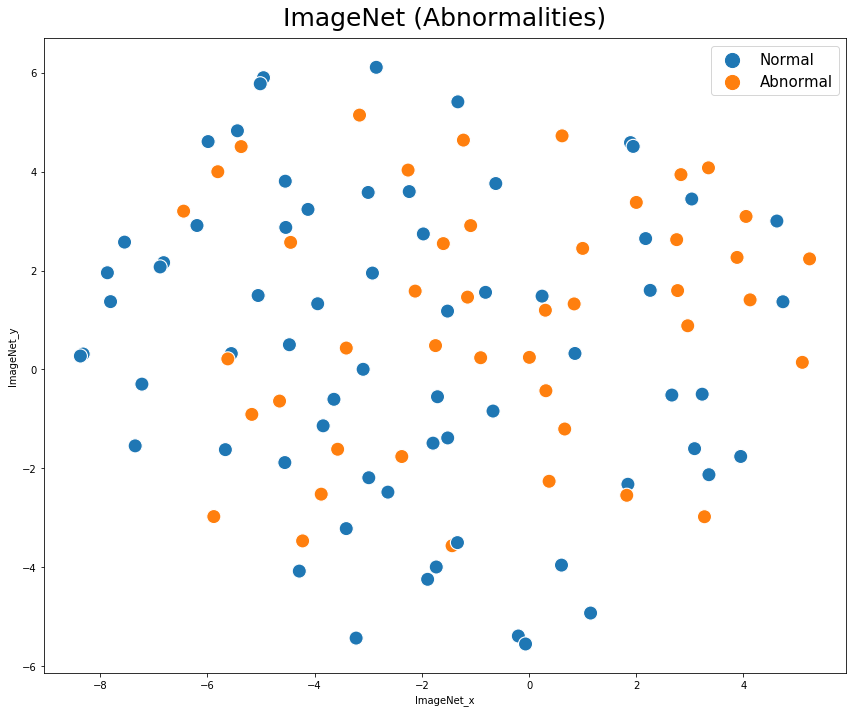

In [21]:
fig, axes = plt.subplots(1,1,figsize=(12,10))

sns.scatterplot(data=test_df, x='ImageNet_x', y='ImageNet_y', hue='no_finding', size = 'no_finding', sizes=[200, 200], ax=axes)
handles, labels = axes.get_legend_handles_labels()

axes.legend(handles, ['Normal', 'Abnormal'], fontsize=15)
plt.title('ImageNet (Abnormalities)', fontsize=25, pad=13 )
plt.tight_layout()


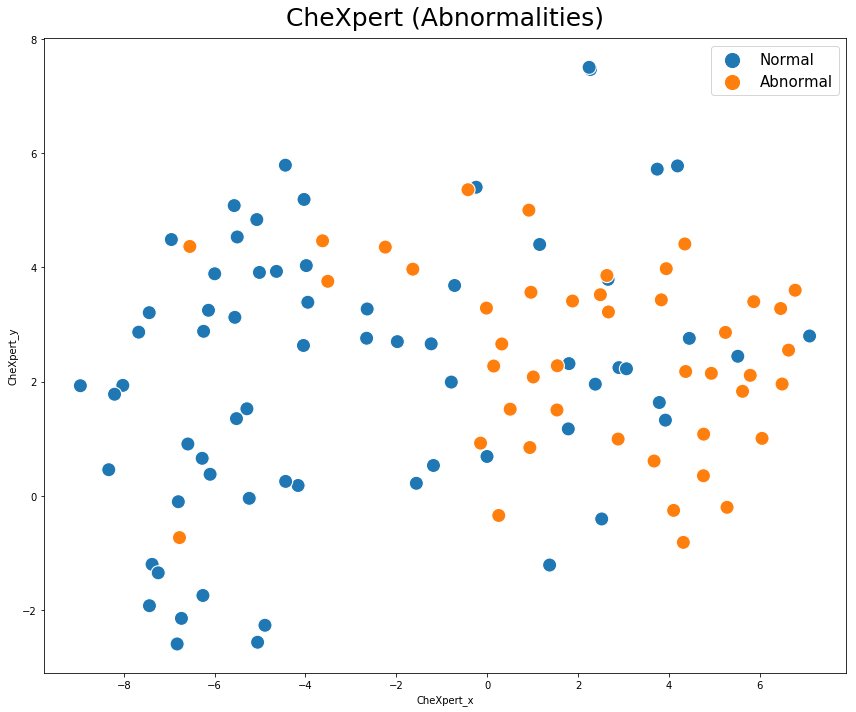

In [22]:
fig, axes = plt.subplots(1,1,figsize=(12,10))

sns.scatterplot(data=test_df, x='CheXpert_x', y='CheXpert_y', hue='no_finding', size = 'no_finding', sizes=[200, 200], ax=axes)
handles, labels = axes.get_legend_handles_labels()

axes.legend(handles, ['Normal', 'Abnormal'], fontsize=15)
plt.title('CheXpert (Abnormalities)', fontsize=25, pad=13 )
plt.tight_layout()


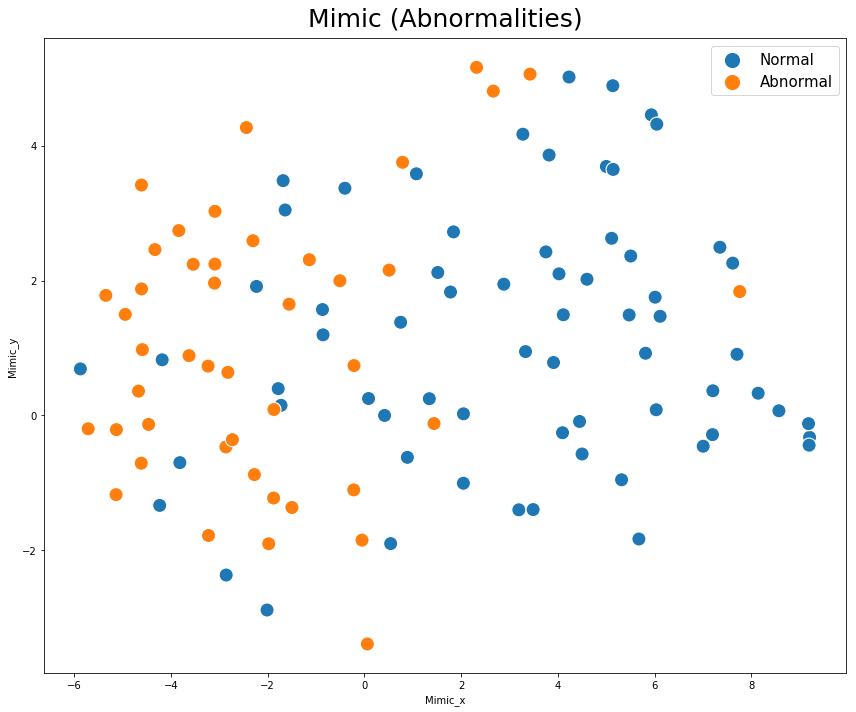

In [23]:
fig, axes = plt.subplots(1,1,figsize=(12,10))

sns.scatterplot(data=test_df, x='Mimic_x', y='Mimic_y', hue='no_finding', size = 'no_finding', sizes=[200, 200], ax=axes)
handles, labels = axes.get_legend_handles_labels()

axes.legend(handles, ['Normal', 'Abnormal'], fontsize=15)
plt.title('Mimic (Abnormalities)', fontsize=25, pad=13 )
plt.tight_layout()


### cardiomegaly, edema, pneumonia, lung_opacity

Text(0.5, 0.93, 'ImageNet')

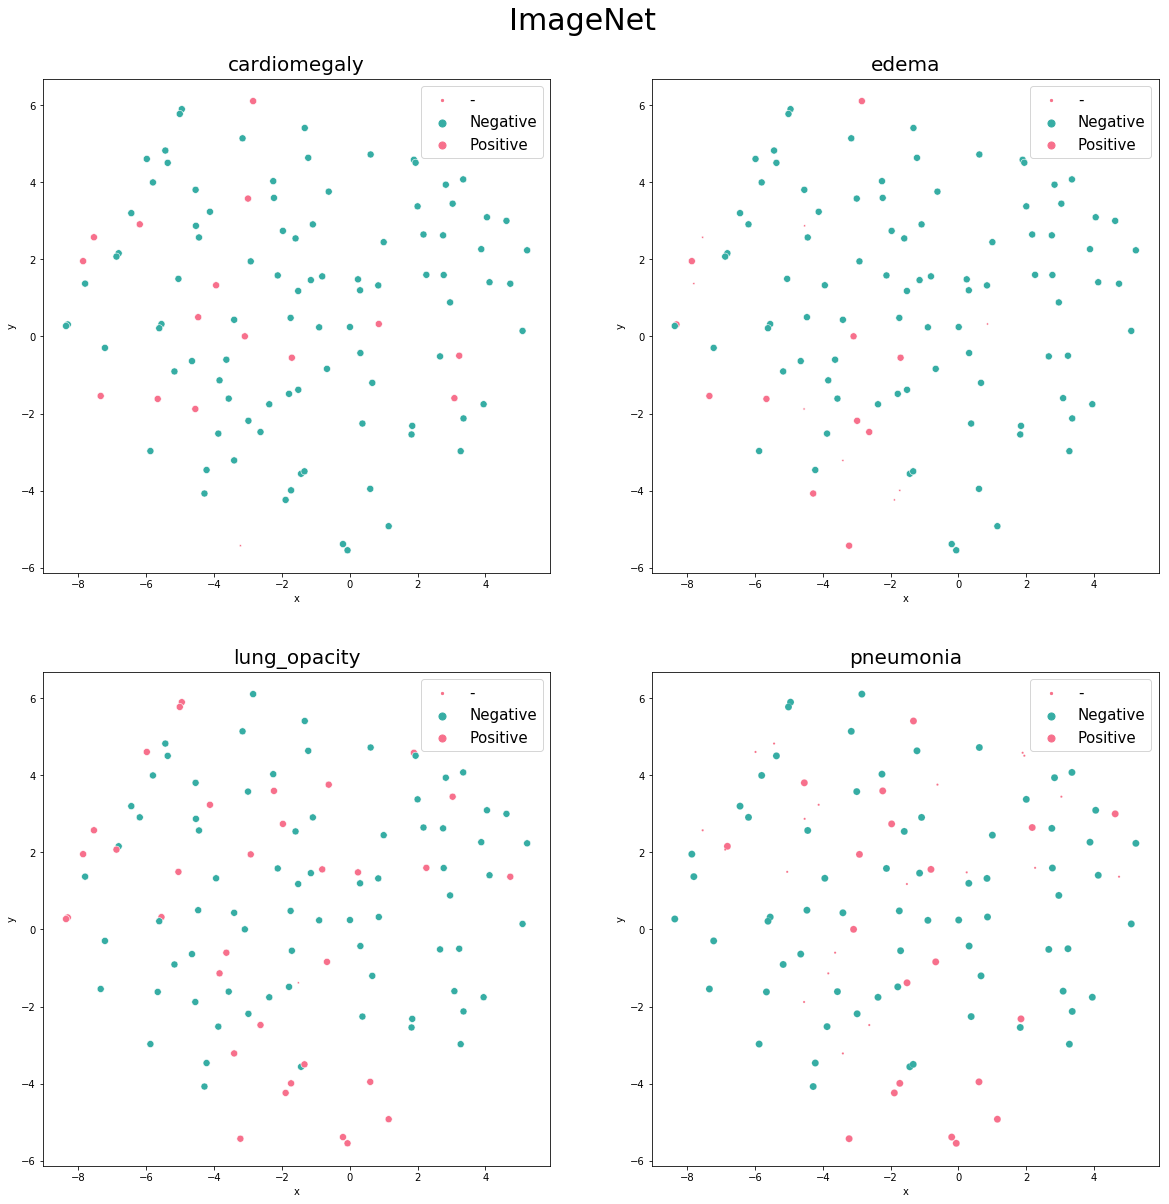

In [46]:
tags = ["cardiomegaly","edema", "lung_opacity","pneumonia"]


fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for idx, tag in enumerate(tags):
    sns.scatterplot(data=test_df, x='ImageNet_x', y='ImageNet_y', hue=tag, size = tag, sizes=[5, 50, 50], ax=axes.flatten()[idx], palette="husl")
    handles, labels = axes.flatten()[idx].get_legend_handles_labels()

    axes.flatten()[idx].legend(handles, ["-", "Negative", "Positive"], fontsize=15, loc='upper right')
    axes.flatten()[idx].set_title(f'{tag}', fontsize=20, pad=8)
    axes.flatten()[idx].set_xlabel('x')
    axes.flatten()[idx].set_ylabel('y')

fig.suptitle("ImageNet", y=0.93, fontsize=30)
    
    

Text(0.5, 0.93, 'CheXpert')

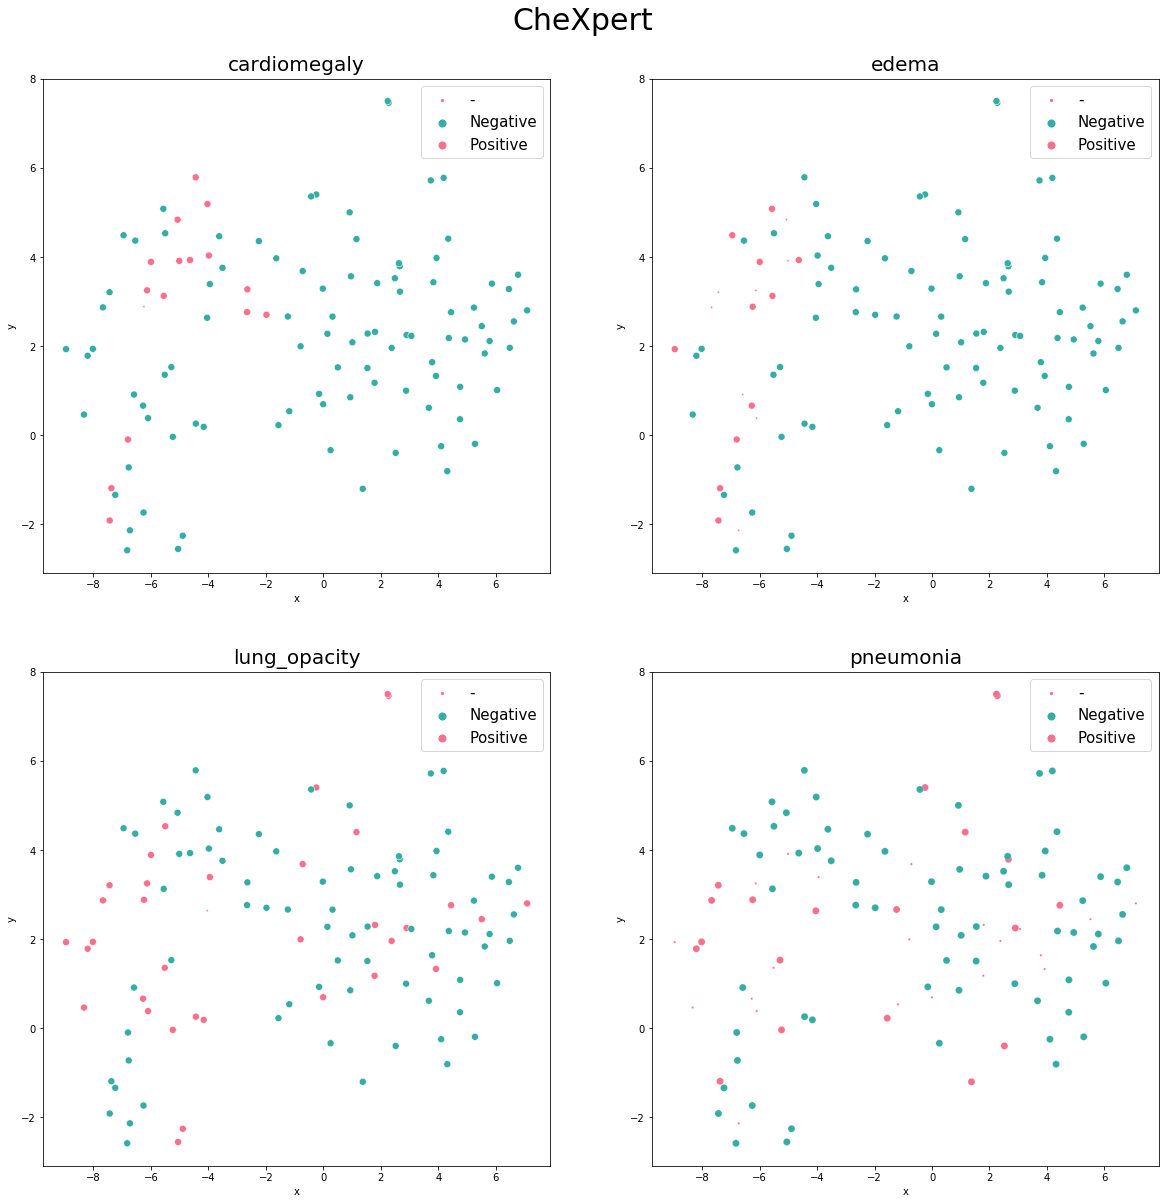

In [47]:
tags = ["cardiomegaly","edema", "lung_opacity","pneumonia"]


fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for idx, tag in enumerate(tags):
    sns.scatterplot(data=test_df, x='CheXpert_x', y='CheXpert_y', hue=tag, size = tag, sizes=[5, 50, 50], ax=axes.flatten()[idx], palette="husl")
    handles, labels = axes.flatten()[idx].get_legend_handles_labels()

    axes.flatten()[idx].legend(handles, ["-", "Negative", "Positive"], fontsize=15, loc='upper right')
    axes.flatten()[idx].set_title(f'{tag}', fontsize=20, pad=8 )
    axes.flatten()[idx].set_xlabel('x')
    axes.flatten()[idx].set_ylabel('y')

fig.suptitle("CheXpert", y=0.93, fontsize=30)
    
    

Text(0.5, 0.93, 'Mimic')

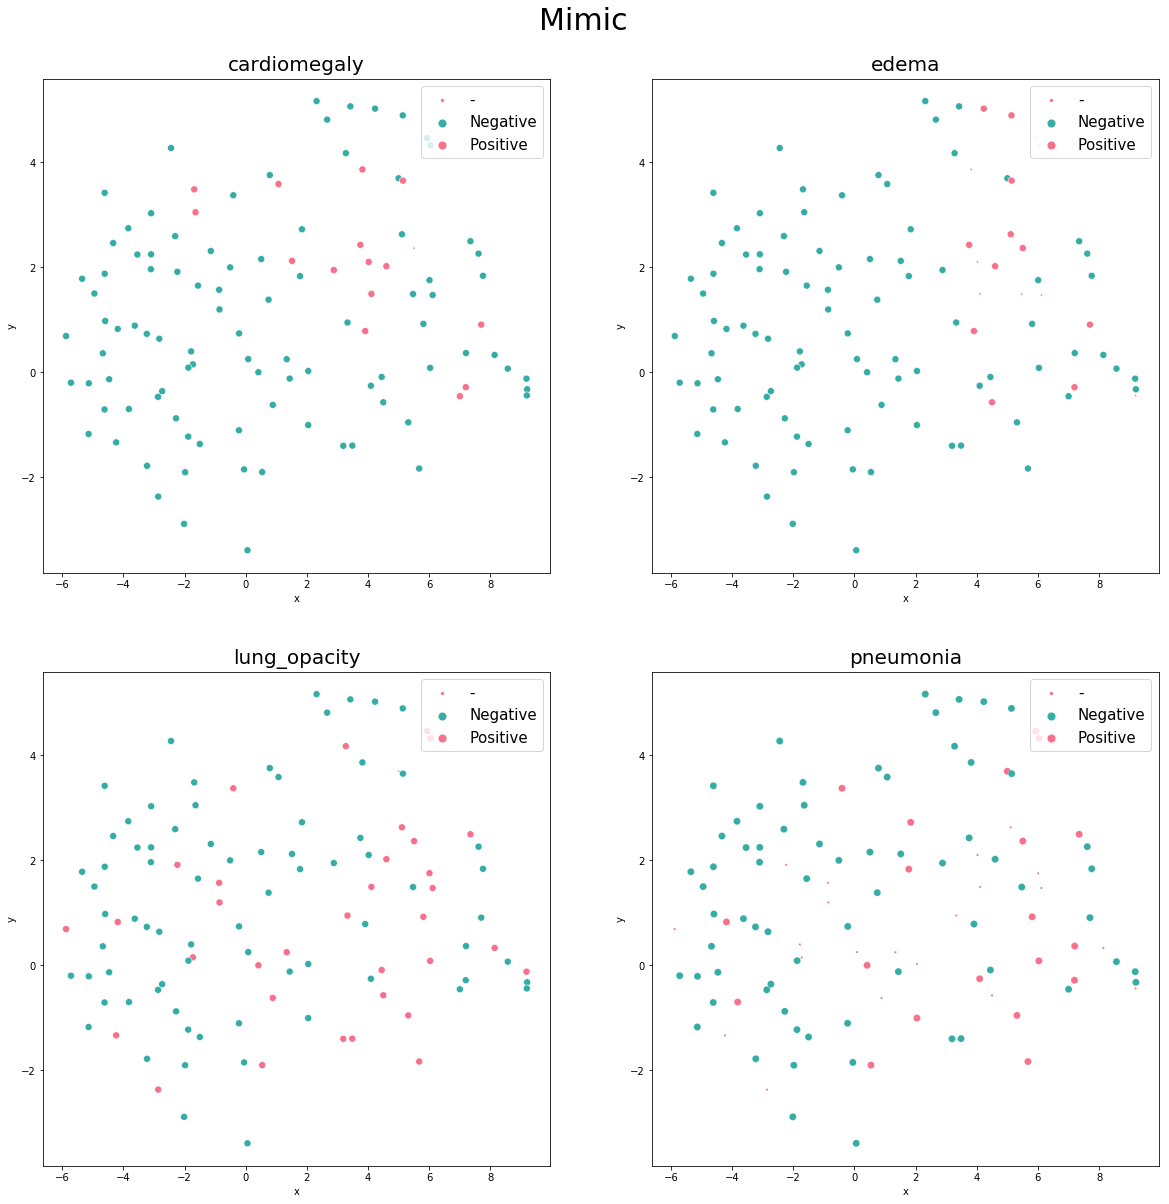

In [49]:
tags = ["cardiomegaly","edema", "lung_opacity","pneumonia"]


fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for idx, tag in enumerate(tags):
    sns.scatterplot(data=test_df, x='Mimic_x', y='Mimic_y', hue=tag, size = tag, sizes=[5, 50, 50], ax=axes.flatten()[idx], palette="husl")
    handles, labels = axes.flatten()[idx].get_legend_handles_labels()

    axes.flatten()[idx].legend(handles, ["-", "Negative", "Positive"], fontsize=15, loc='upper right')
    axes.flatten()[idx].set_title(f'{tag}', fontsize=20, pad=8 )
    axes.flatten()[idx].set_xlabel('x')
    axes.flatten()[idx].set_ylabel('y')

fig.suptitle("Mimic", y=0.93, fontsize=30)
    
    

## Unique Labels

In [49]:
test_df.iloc[:, 45:]

,cardiomegaly__chx,consolidation__chx,edema__chx,enlarged_cardiomediastinum__chx,fracture__chx,lung_lesion__chx,lung_opacity__chx,no_finding__chx,pleural_effusion__chx,pleural_other__chx,...,cxr_exam_indication,ImageNet_features,CheXpert_features,Mimic_features,ImageNet_x,ImageNet_y,CheXpert_x,CheXpert_y,Mimic_x,Mimic_y
12,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,___-year-old with shortness of breath.,"[1.8363315e-05, 0.0015117069, 0.0028695802, 0....","[-0.00082731096, -0.0014777514, 0.0024943152, ...","[0.0012346965, -0.0062856274, 0.0024841006, 0....",-0.029733,-5.998926,-6.671478,1.341641,-2.424452,-0.290461
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,Leg swelling and increasing shortness of breat...,"[0.00011761118, -6.2584118e-06, 0.0032668891, ...","[-0.00082611246, -0.0022984836, 0.0034009577, ...","[0.0011376258, -0.0041477825, 0.002669539, 0.0...",-3.496863,-3.105247,-5.982760,-0.682089,1.149359,0.441151
47,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,"___F with new anemia, dCHF // ? cardiac size,...","[-7.962588e-05, -0.0016170534, 0.0036757514, 0...","[-0.0008302321, -0.0017723284, 0.002253395, -0...","[0.0026432038, -0.007178956, 0.0020236813, 0.0...",-4.696343,-1.414475,-5.662836,3.666903,-3.728647,0.397858
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Clinical history of worsening intermittent che...,"[-8.649691e-05, -0.001071872, 0.0030129743, 0....","[-0.0008205154, -0.00017061381, 0.0022765407, ...","[0.0016409811, -0.007078702, -6.369395e-05, 0....",-0.914682,2.273926,-3.079558,4.922745,-5.262578,-1.730402
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"___M with new dx aortic stenosis, CHF in conte...","[-0.00012766053, -0.00092017016, 0.004207812, ...","[-0.0008513633, -0.0032231691, 0.004731984, -0...","[0.0024840771, -0.0071317027, 0.0036359872, 0....",2.035477,-1.586055,0.106888,-5.859656,6.002704,-0.154012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"___-year-old man status post liver transplant,...","[-0.00012164093, -0.00054534036, 0.0034341344,...","[-0.0008389459, -0.0011656989, 0.0028972486, -...","[0.0026299735, -0.008608142, 0.0030783645, 0.0...",4.331984,-4.251290,-2.390185,-2.640769,0.300396,-1.785274
1058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,Fever and lightheadedness. Assess for pneumonia.,"[2.5816742e-05, -0.00039198477, 0.0033521703, ...","[-0.0008289589, -0.0027765278, 0.0028563093, -...","[0.0010917198, -0.012121952, 0.0032240043, 0.0...",1.703924,3.060128,-4.752653,-1.150068,0.384210,3.707108
1078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,Palpitations. Evaluate for pneumothorax,"[-4.531324e-05, -0.001264097, 0.0037034124, 0....","[-0.0008383758, -0.0021021632, 0.0045800214, -...","[0.0010595114, -0.010996196, 0.003507673, 0.00...",6.339056,1.122242,-0.900640,-5.564804,2.258097,2.201900
1080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,Slurred speech and altered mental status. Eval...,"[3.044197e-05, -0.0021894926, 0.0028626397, 0....","[-0.00083942583, 9.693585e-05, 0.002224399, -0...","[0.0029112562, -0.0016933542, 0.0010553064, 0....",-3.191529,1.729652,-2.490426,0.696844,5.225953,-2.775807


In [50]:
import seaborn as sns

**column 이름 조절**

In [51]:
test_df = test_df.drop(['pneumonia'], axis=1)
test_df.columns = [column[:-5] if '__chx' in column else column for column in test_df.columns ]

In [56]:
test_df.iloc[:, 43:57]

,atelectasis,cardiomegaly,consolidation,edema,enlarged_cardiomediastinum,fracture,lung_lesion,lung_opacity,no_finding,pleural_effusion,pleural_other,pneumonia,pneumothorax,support_devices
12,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
56,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [75]:
test_df

,dicom_id,path,study_id,patient_id,stay_id,gender,anchor_age,image_top_pad,image_bottom_pad,image_left_pad,...,cxr_exam_indication,ImageNet_features,CheXpert_features,Mimic_features,ImageNet_x,ImageNet_y,CheXpert_x,CheXpert_y,Mimic_x,Mimic_y
12,310ed1a6-ee306bc9-07d8d696-d5e3caa3-37749a62,files/p17/p17051517/s58376214/310ed1a6-ee306bc...,58376214,17051517,38424362,F,30 - 40,0,0,484,...,___-year-old with shortness of breath.,"[1.8363315e-05, 0.0015117069, 0.0028695802, 0....","[-0.00082731096, -0.0014777514, 0.0024943152, ...","[0.0012346965, -0.0062856274, 0.0024841006, 0....",-0.029733,-5.998926,-6.671478,1.341641,-2.424452,-0.290461
38,d800100e-3c9881c1-749eb770-e1011921-222f1146,files/p12/p12199702/s56575847/d800100e-3c9881c...,56575847,12199702,39228461,F,40 - 50,0,0,534,...,Leg swelling and increasing shortness of breat...,"[0.00011761118, -6.2584118e-06, 0.0032668891, ...","[-0.00082611246, -0.0022984836, 0.0034009577, ...","[0.0011376258, -0.0041477825, 0.002669539, 0.0...",-3.496863,-3.105247,-5.982760,-0.682089,1.149359,0.441151
47,74ebeb28-f0b77333-d4f66e5b-c2aaf97b-92cba2b5,files/p11/p11133246/s58344200/74ebeb28-f0b7733...,58344200,11133246,30332321,F,40 - 50,0,0,534,...,"___F with new anemia, dCHF // ? cardiac size,...","[-7.962588e-05, -0.0016170534, 0.0036757514, 0...","[-0.0008302321, -0.0017723284, 0.002253395, -0...","[0.0026432038, -0.007178956, 0.0020236813, 0.0...",-4.696343,-1.414475,-5.662836,3.666903,-3.728647,0.397858
56,08769631-1f95c38a-af801b03-48492ec0-03efd987,files/p18/p18519675/s50956819/08769631-1f95c38...,50956819,18519675,36900518,M,40 - 50,86,86,448,...,Clinical history of worsening intermittent che...,"[-8.649691e-05, -0.001071872, 0.0030129743, 0....","[-0.0008205154, -0.00017061381, 0.0022765407, ...","[0.0016409811, -0.007078702, -6.369395e-05, 0....",-0.914682,2.273926,-3.079558,4.922745,-5.262578,-1.730402
62,ecdcd18f-8dc1dc75-7166c1b1-4b31dfaf-d3cf9e9f,files/p12/p12616585/s53490229/ecdcd18f-8dc1dc7...,53490229,12616585,38791792,M,40 - 50,0,0,534,...,"___M with new dx aortic stenosis, CHF in conte...","[-0.00012766053, -0.00092017016, 0.004207812, ...","[-0.0008513633, -0.0032231691, 0.004731984, -0...","[0.0024840771, -0.0071317027, 0.0036359872, 0....",2.035477,-1.586055,0.106888,-5.859656,6.002704,-0.154012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,2d97c2cf-fa064bc4-926d7a8f-36a81b07-f59fb37e,files/p18/p18786508/s54099695/2d97c2cf-fa064bc...,54099695,18786508,34991601,M,70 - 80,0,0,534,...,"___-year-old man status post liver transplant,...","[-0.00012164093, -0.00054534036, 0.0034341344,...","[-0.0008389459, -0.0011656989, 0.0028972486, -...","[0.0026299735, -0.008608142, 0.0030783645, 0.0...",4.331984,-4.251290,-2.390185,-2.640769,0.300396,-1.785274
1058,ab79192c-62b95431-10ed50cf-b34ee361-cc410717,files/p16/p16641795/s57329838/ab79192c-62b9543...,57329838,16641795,32316883,M,70 - 80,86,86,448,...,Fever and lightheadedness. Assess for pneumonia.,"[2.5816742e-05, -0.00039198477, 0.0033521703, ...","[-0.0008289589, -0.0027765278, 0.0028563093, -...","[0.0010917198, -0.012121952, 0.0032240043, 0.0...",1.703924,3.060128,-4.752653,-1.150068,0.384210,3.707108
1078,78830bfd-5c6cded1-9c844764-6b3b5c2b-979da97b,files/p19/p19541033/s55836463/78830bfd-5c6cded...,55836463,19541033,34003309,M,70 - 80,86,86,448,...,Palpitations. Evaluate for pneumothorax,"[-4.531324e-05, -0.001264097, 0.0037034124, 0....","[-0.0008383758, -0.0021021632, 0.0045800214, -...","[0.0010595114, -0.010996196, 0.003507673, 0.00...",6.339056,1.122242,-0.900640,-5.564804,2.258097,2.201900
1080,9c01aecd-dc299044-a9fac53a-09a86bf1-58878e8a,files/p10/p10074605/s59245019/9c01aecd-dc29904...,59245019,10074605,37505021,M,70 - 80,0,0,534,...,Slurred speech and altered mental status. Eval...,"[3.044197e-05, -0.0021894926, 0.0028626397, 0....","[-0.00083942583, 9.693585e-05, 0.002224399, -0...","[0.0029112562, -0.0016933542, 0.0010553064, 0....",-3.191529,1.729652,-2.490426,0.69684

In [76]:
print('unique sample:', len(set([line[45:] for line in load_lines(mimic_test)])))
print('all sample:', len(load_lines(mimic_test))) 

unique sample: 29
all sample: 110


In [80]:
test_df['str_labels']=[line[45:] for line in load_lines(mimic_test)]

In [81]:
test_df

,dicom_id,path,study_id,patient_id,stay_id,gender,anchor_age,image_top_pad,image_bottom_pad,image_left_pad,...,ImageNet_features,CheXpert_features,Mimic_features,ImageNet_x,ImageNet_y,CheXpert_x,CheXpert_y,Mimic_x,Mimic_y,str_labels
12,310ed1a6-ee306bc9-07d8d696-d5e3caa3-37749a62,files/p17/p17051517/s58376214/310ed1a6-ee306bc...,58376214,17051517,38424362,F,30 - 40,0,0,484,...,"[1.8363315e-05, 0.0015117069, 0.0028695802, 0....","[-0.00082731096, -0.0014777514, 0.0024943152, ...","[0.0012346965, -0.0062856274, 0.0024841006, 0....",-0.029733,-5.998926,-6.671478,1.341641,-2.424452,-0.290461,0 1 0 1 0 0 0 0 0 0 0 0 0 0
38,d800100e-3c9881c1-749eb770-e1011921-222f1146,files/p12/p12199702/s56575847/d800100e-3c9881c...,56575847,12199702,39228461,F,40 - 50,0,0,534,...,"[0.00011761118, -6.2584118e-06, 0.0032668891, ...","[-0.00082611246, -0.0022984836, 0.0034009577, ...","[0.0011376258, -0.0041477825, 0.002669539, 0.0...",-3.496863,-3.105247,-5.982760,-0.682089,1.149359,0.441151,0 0 0 0 0 0 0 0 1 0 0 0 0 0
47,74ebeb28-f0b77333-d4f66e5b-c2aaf97b-92cba2b5,files/p11/p11133246/s58344200/74ebeb28-f0b7733...,58344200,11133246,30332321,F,40 - 50,0,0,534,...,"[-7.962588e-05, -0.0016170534, 0.0036757514, 0...","[-0.0008302321, -0.0017723284, 0.002253395, -0...","[0.0026432038, -0.007178956, 0.0020236813, 0.0...",-4.696343,-1.414475,-5.662836,3.666903,-3.728647,0.397858,0 0 0 0 0 0 0 0 0 1 0 0 0 0
56,08769631-1f95c38a-af801b03-48492ec0-03efd987,files/p18/p18519675/s50956819/08769631-1f95c38...,50956819,18519675,36900518,M,40 - 50,86,86,448,...,"[-8.649691e-05, -0.001071872, 0.0030129743, 0....","[-0.0008205154, -0.00017061381, 0.0022765407, ...","[0.0016409811, -0.007078702, -6.369395e-05, 0....",-0.914682,2.273926,-3.079558,4.922745,-5.262578,-1.730402,1 0 0 0 0 0 0 0 0 0 0 0 0 0
62,ecdcd18f-8dc1dc75-7166c1b1-4b31dfaf-d3cf9e9f,files/p12/p12616585/s53490229/ecdcd18f-8dc1dc7...,53490229,12616585,38791792,M,40 - 50,0,0,534,...,"[-0.00012766053, -0.00092017016, 0.004207812, ...","[-0.0008513633, -0.0032231691, 0.004731984, -0...","[0.0024840771, -0.0071317027, 0.0036359872, 0....",2.035477,-1.586055,0.106888,-5.859656,6.002704,-0.154012,0 0 0 0 0 0 0 0 1 0 0 0 0 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,2d97c2cf-fa064bc4-926d7a8f-36a81b07-f59fb37e,files/p18/p18786508/s54099695/2d97c2cf-fa064bc...,54099695,18786508,34991601,M,70 - 80,0,0,534,...,"[-0.00012164093, -0.00054534036, 0.0034341344,...","[-0.0008389459, -0.0011656989, 0.0028972486, -...","[0.0026299735, -0.008608142, 0.0030783645, 0.0...",4.331984,-4.251290,-2.390185,-2.640769,0.300396,-1.785274,0 0 0 0 0 0 0 0 1 0 0 0 0 0
1058,ab79192c-62b95431-10ed50cf-b34ee361-cc410717,files/p16/p16641795/s57329838/ab79192c-62b9543...,57329838,16641795,32316883,M,70 - 80,86,86,448,...,"[2.5816742e-05, -0.00039198477, 0.0033521703, ...","[-0.0008289589, -0.0027765278, 0.0028563093, -...","[0.0010917198, -0.012121952, 0.0032240043, 0.0...",1.703924,3.060128,-4.752653,-1.150068,0.384210,3.707108,0 0 0 0 0 0 0 0 1 0 0 0 0 0
1078,78830bfd-5c6cded1-9c844764-6b3b5c2b-979da97b,files/p19/p19541033/s55836463/78830bfd-5c6cded...,55836463,19541033,34003309,M,70 - 80,86,86,448,...,"[-4.531324e-05, -0.001264097, 0.0037034124, 0....","[-0.0008383758, -0.0021021632, 0.0045800214, -...","[0.0010595114, -0.010996196, 0.003507673, 0.00...",6.339056,1.122242,-0.900640,-5.564804,2.258097,2.201900,0 0 0 0 0 0 0 0 1 0 0 0 0 0
1080,9c01aecd-dc299044-a9fac53a-09a86bf1-58878e8a,files/p10/p10074605/s59245019/9c01aecd-dc29904...,59245019,10074605,37505021,M,70 - 80,0,0,534,...,"[3.044197e-05, -0.0021894926, 0.0028626397, 0....","[-0.00083942583, 9.693585e-05, 0.002224399, -0...","[0.0029112562, -0.0016933542, 0.0010553064, 0....",-3.191529,1.729652,-2.490426,0.696844,5.225953,-2.775807,0 0 0 0 0 0 0 0 1 0 0 0 0 0


In [74]:
# unique_array=np.ones((29, 100))*(-1)

# print(unique_array)

# for i in range(len(test_df)):
#     for j in range(i+1, len(test_df)):
#         if (test_df.iloc[i, 43:57] == test_df.iloc[j, 43:57]).all():
            
            

SyntaxError: invalid syntax (1020310153.py, line 8)

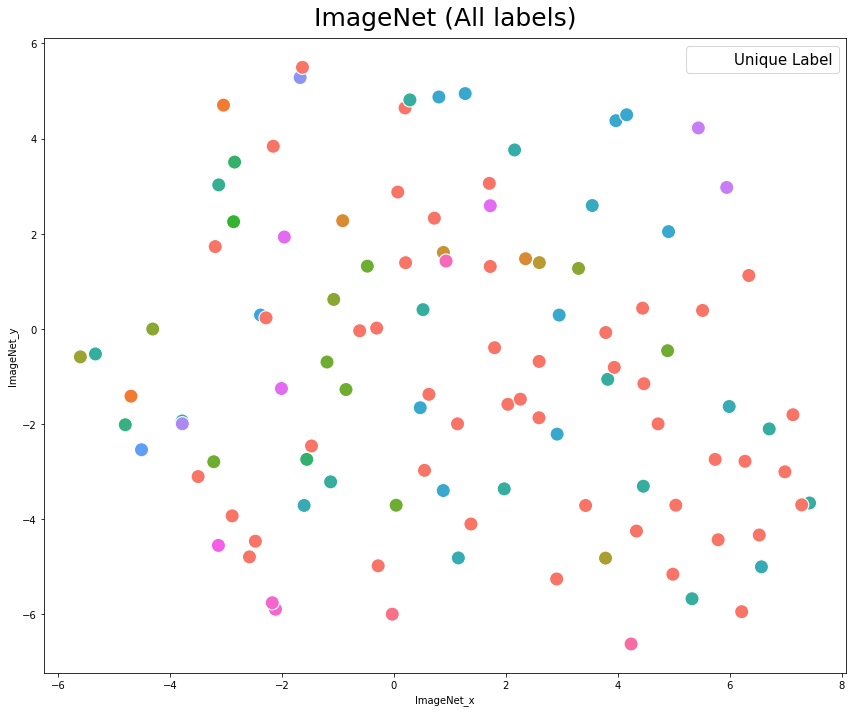

In [94]:
fig, axes = plt.subplots(1,1,figsize=(12,10))

sns.scatterplot(data=test_df, x='ImageNet_x', y='ImageNet_y', hue='str_labels', size = 'no_finding', sizes=[200, 200], ax=axes)
handles, labels = axes.get_legend_handles_labels()

axes.legend(handles, ['Unique Label'], fontsize=15)
plt.title('ImageNet (All labels)', fontsize=25, pad=13 )
plt.tight_layout()


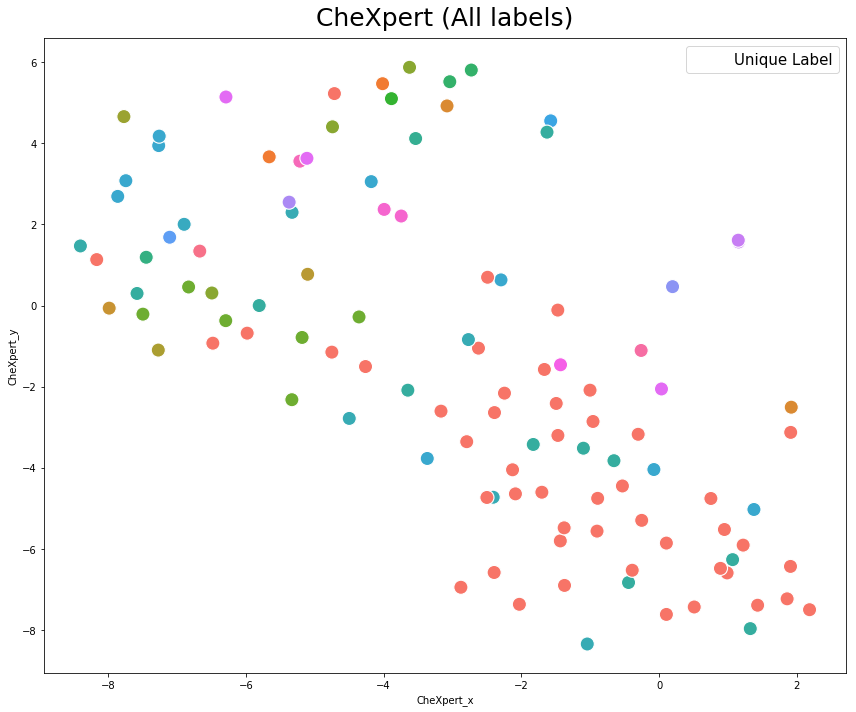

In [95]:
fig, axes = plt.subplots(1,1,figsize=(12,10))

sns.scatterplot(data=test_df, x='CheXpert_x', y='CheXpert_y', hue='str_labels', size = 'no_finding', sizes=[200, 200], ax=axes)
handles, labels = axes.get_legend_handles_labels()

axes.legend(handles, ['Unique Label'], fontsize=15)
plt.title('CheXpert (All labels)', fontsize=25, pad=13 )
plt.tight_layout()


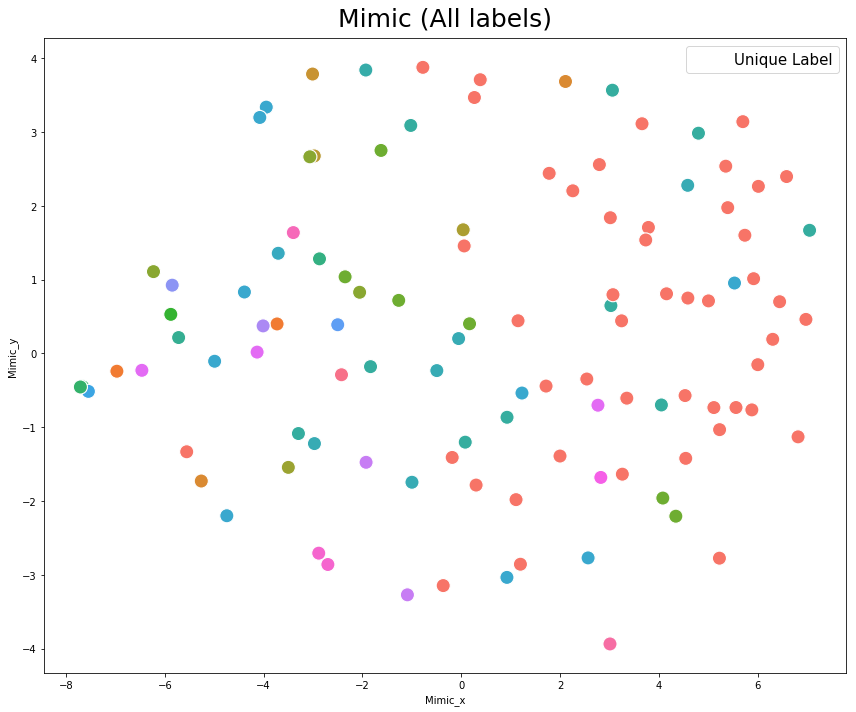

In [96]:
fig, axes = plt.subplots(1,1,figsize=(12,10))

sns.scatterplot(data=test_df, x='Mimic_x', y='Mimic_y', hue='str_labels', size = 'no_finding', sizes=[200, 200], ax=axes)
handles, labels = axes.get_legend_handles_labels()

axes.legend(handles, ['Unique Label'], fontsize=15)
plt.title('Mimic (All labels)', fontsize=25, pad=13 )
plt.tight_layout()
